In [101]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer
from tqdm.notebook import tqdm


In [2]:
data = pd.read_csv("/data/work/wessex/Wessex/test/Brunel_track_seeds_with_target.csv")
target = data.particle_isDown_noVelo 
features = data.drop(["Unnamed: 0", 
                      "Unnamed: 0_x", # index
                      "Unnamed: 0_y",
                      "eventID",
                      "particle_key",
                      "particle_hasUT",
                      "particle_pid", # this are MC info
                      "particle_hasScifi",
                      "particle_isDown_noVelo",
                      "particle_isDown",
                      "particle_hasVelo",
                      "track_charge",
                      "track_position_z",
                     ], axis=1)
features.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [6]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [8]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [9]:
datasets["valid"].__getitem__(0)

(tensor([ 5.5752e-02,  6.0465e-01,  3.2267e-01,  7.1693e-01, -3.9098e-03,
         -5.5659e-01,  7.8569e-01,  2.9878e-01, -5.9557e-01, -3.3483e-04,
         -1.3694e-01, -3.9947e-01,  1.2029e-01], device='cuda:0'),
 tensor(0., device='cuda:0'))

In [10]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=128,
                   shuffle=True,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [11]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[ 0.0434,  1.3710,  0.5385,  ..., -1.0083,  1.1475,  0.0943],
        [-1.4580, -1.4504, -1.2241,  ..., -1.0308,  0.9639, -1.3900],
        [ 1.5216, -2.0646,  0.6484,  ..., -1.3881,  0.5593,  1.5341],
        ...,
        [ 0.0515,  0.5779,  0.2836,  ..., -0.0874, -0.7527,  0.2849],
        [-0.0191,  0.9217, -0.2211,  ..., -0.5854, -0.6030, -0.1133],
        [ 0.0304,  1.4806,  0.3856,  ..., -1.0862, -0.1626,  0.1439]],
       device='cuda:0') 128
target tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0.

In [26]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            batch_iterator = tqdm(iter(dataloaders[phase]), leave=False, total=len(dataloaders[phase]))

        
            for i, batch in enumerate(batch_iterator):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

# Build the shallow model

In [20]:
class NHiddenTrackingNetwork(torch.nn.Module):
    def __init__(self, inputs,n_hidden, hidden_dict):
        super(NHiddenTrackingNetwork, self).__init__()
        if n_hidden < 3: 
          raise ValueError("n_hidden must be greater than 2")
        self.input_layer = nn.Linear(inputs, hidden_dict[0])
        self.layers = nn.ModuleList()
        for layer_it in range(n_hidden-1):
          self.layers.append(nn.Linear(hidden_dict[layer_it],
                                       hidden_dict[layer_it+1]))
        self.output_layer = nn.Linear(hidden_dict[n_hidden-1], 2)
        self.inputs = inputs
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        for layer in self.layers:
          x = layer(x)
          x = F.relu(x)
        x = self.output_layer(x)
        return x

In [21]:
n_hidden = {0:40,
            1:30,
           2:20,
           3:10}

model = NHiddenTrackingNetwork(X_train.shape[1], 4, n_hidden).to(device)
model

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [22]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
input_layer.weight 	 torch.Size([40, 13])
input_layer.bias 	 torch.Size([40])
layers.0.weight 	 torch.Size([30, 40])
layers.0.bias 	 torch.Size([30])
layers.1.weight 	 torch.Size([20, 30])
layers.1.bias 	 torch.Size([20])
layers.2.weight 	 torch.Size([10, 20])
layers.2.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [23]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------


train loss: 0.3944, train acc: 0.8552, elapsed:161.1246


valid loss: 0.3901, valid acc: 0.8556, elapsed:18.2012

Epoch 2/10
----------


train loss: 0.3861, train acc: 0.8551, elapsed:169.9736


valid loss: 0.3802, valid acc: 0.8554, elapsed:18.4734

Epoch 3/10
----------


train loss: 0.3767, train acc: 0.8561, elapsed:163.0501


valid loss: 0.3709, valid acc: 0.8589, elapsed:18.7440

Epoch 4/10
----------


train loss: 0.3679, train acc: 0.8608, elapsed:162.9221


valid loss: 0.3669, valid acc: 0.8628, elapsed:18.5765

Epoch 5/10
----------


train loss: 0.3636, train acc: 0.8634, elapsed:160.4217


valid loss: 0.3628, valid acc: 0.8640, elapsed:18.4710

Epoch 6/10
----------


train loss: 0.3615, train acc: 0.8642, elapsed:161.9341


valid loss: 0.3608, valid acc: 0.8642, elapsed:21.7266

Epoch 7/10
----------


train loss: 0.3600, train acc: 0.8647, elapsed:163.7655


valid loss: 0.3588, valid acc: 0.8652, elapsed:17.9858

Epoch 8/10
----------


train loss: 0.3589, train acc: 0.8651, elapsed:168.0002


valid loss: 0.3577, valid acc: 0.8654, elapsed:18.7983

Epoch 9/10
----------


train loss: 0.3578, train acc: 0.8654, elapsed:169.8548


valid loss: 0.3565, valid acc: 0.8657, elapsed:20.2140

Epoch 10/10
----------


train loss: 0.3568, train acc: 0.8656, elapsed:163.8741


valid loss: 0.3552, valid acc: 0.8662, elapsed:18.0126
training took:  1834.1298468320165


In [118]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    pred = F.softmax(output).cpu().detach().numpy()[:,1]
    fpr, tpr, thresholds = roc_curve(Y,pred )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.4f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.8, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



In [29]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


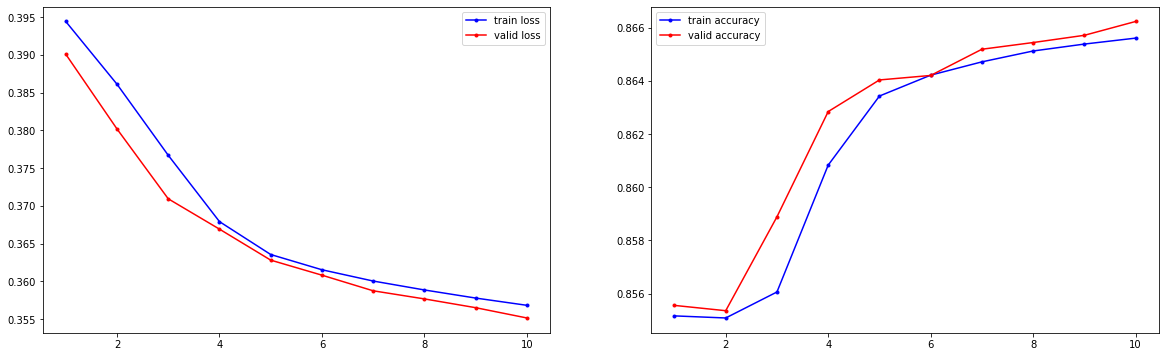

In [30]:
plot_training_classification(run_hist)

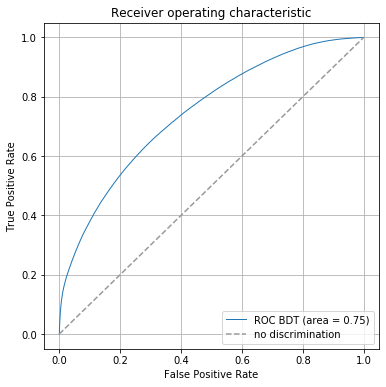

In [31]:
print_roc(model,X_valid, Y_valid )

In [32]:
for param in model.named_parameters():
  print(param)


('input_layer.weight', Parameter containing:
tensor([[-3.9981e-01,  7.3016e-02, -2.7410e-01, -3.7644e-03,  6.1933e-01,
         -2.1195e-02,  3.7706e-01,  3.4614e-01,  1.5167e-02,  7.2129e-01,
          6.4822e-02, -1.6074e-01,  1.2925e-01],
        [ 4.1454e-01, -7.9823e-02,  1.2972e-01,  3.2421e-02,  3.8442e-02,
         -2.2268e-01,  2.3165e-01,  3.4128e-01,  2.0116e-01,  1.6422e+00,
          2.2097e-01, -6.5440e-02, -1.7688e-02],
        [ 3.6455e-02,  4.1489e-03, -4.6833e-01,  3.2288e-02,  6.6997e-01,
          1.0412e-01, -1.5957e-01,  3.8589e-01, -1.2943e-01,  1.5910e+00,
          4.1948e-02,  1.4317e-01, -4.4266e-02],
        [-3.0319e-01, -1.5058e-01, -3.6314e-02,  2.1771e-02,  3.5879e-01,
         -2.0662e-02,  2.2894e-01,  3.1040e-01,  2.4922e-02,  5.0365e-01,
         -4.5619e-02, -2.1305e-01, -2.7092e-01],
        [-1.0799e-01, -1.2097e-01,  6.3307e-01, -2.5390e-02,  8.5079e-01,
         -2.5889e-02,  2.5178e-01,  3.0788e-01,  2.6075e-02,  4.3367e-02,
         -5.5284e-0

In [33]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 2642


In [34]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN.pt")


In [35]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.3560, train acc: 0.8657, elapsed:155.1411


valid loss: 0.3545, valid acc: 0.8662, elapsed:18.1532

Epoch 2/10
----------


train loss: 0.3552, train acc: 0.8658, elapsed:159.2431


valid loss: 0.3558, valid acc: 0.8660, elapsed:18.2312

Epoch 3/10
----------


train loss: 0.3545, train acc: 0.8659, elapsed:156.8989


valid loss: 0.3534, valid acc: 0.8663, elapsed:18.2012

Epoch 4/10
----------


train loss: 0.3537, train acc: 0.8660, elapsed:160.1084


valid loss: 0.3524, valid acc: 0.8665, elapsed:19.9547

Epoch 5/10
----------


train loss: 0.3530, train acc: 0.8660, elapsed:160.0925


valid loss: 0.3530, valid acc: 0.8659, elapsed:17.9611

Epoch 6/10
----------


train loss: 0.3523, train acc: 0.8660, elapsed:156.5634


valid loss: 0.3518, valid acc: 0.8665, elapsed:18.1393

Epoch 7/10
----------


train loss: 0.3516, train acc: 0.8661, elapsed:156.4206


valid loss: 0.3510, valid acc: 0.8662, elapsed:18.0889

Epoch 8/10
----------


train loss: 0.3509, train acc: 0.8662, elapsed:159.4737


valid loss: 0.3503, valid acc: 0.8663, elapsed:17.9585

Epoch 9/10
----------


train loss: 0.3503, train acc: 0.8663, elapsed:165.8316


valid loss: 0.3491, valid acc: 0.8666, elapsed:18.0874

Epoch 10/10
----------


train loss: 0.3497, train acc: 0.8664, elapsed:158.2179


valid loss: 0.3488, valid acc: 0.8668, elapsed:18.2083
training took:  1770.9811489430722


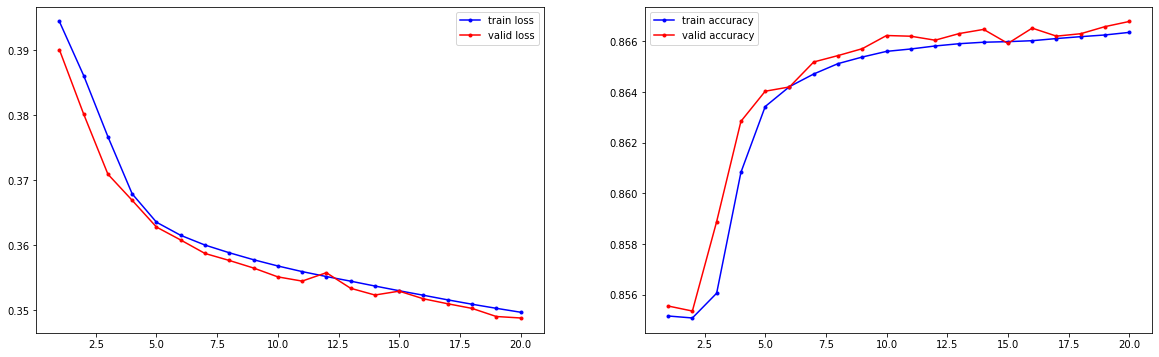

In [36]:
plot_training_classification(run_hist)

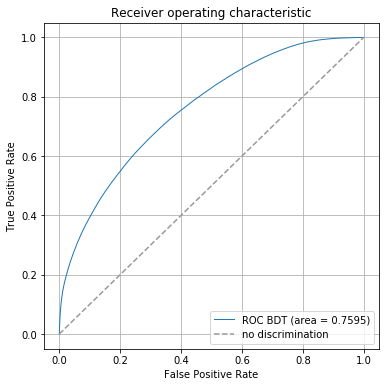

In [39]:
print_roc(model,X_valid, Y_valid )

In [40]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=20)


Epoch 1/20
----------


train loss: 0.3492, train acc: 0.8664, elapsed:160.3557


valid loss: 0.3488, valid acc: 0.8665, elapsed:18.1312

Epoch 2/20
----------


train loss: 0.3489, train acc: 0.8665, elapsed:160.5328


valid loss: 0.3481, valid acc: 0.8669, elapsed:17.7742

Epoch 3/20
----------


train loss: 0.3486, train acc: 0.8665, elapsed:159.7310


valid loss: 0.3482, valid acc: 0.8668, elapsed:17.8366

Epoch 4/20
----------


train loss: 0.3484, train acc: 0.8666, elapsed:162.0598


valid loss: 0.3480, valid acc: 0.8669, elapsed:21.1857

Epoch 5/20
----------


train loss: 0.3481, train acc: 0.8666, elapsed:160.8344


valid loss: 0.3476, valid acc: 0.8667, elapsed:18.2009

Epoch 6/20
----------


train loss: 0.3479, train acc: 0.8666, elapsed:160.4524


valid loss: 0.3474, valid acc: 0.8670, elapsed:19.6636

Epoch 7/20
----------


train loss: 0.3477, train acc: 0.8667, elapsed:159.3825


valid loss: 0.3483, valid acc: 0.8669, elapsed:18.0474

Epoch 8/20
----------


train loss: 0.3476, train acc: 0.8668, elapsed:162.8943


valid loss: 0.3471, valid acc: 0.8669, elapsed:18.2711

Epoch 9/20
----------


train loss: 0.3474, train acc: 0.8667, elapsed:158.2175


valid loss: 0.3471, valid acc: 0.8669, elapsed:18.1890

Epoch 10/20
----------


train loss: 0.3473, train acc: 0.8668, elapsed:159.7398


valid loss: 0.3465, valid acc: 0.8671, elapsed:18.2681

Epoch 11/20
----------


train loss: 0.3471, train acc: 0.8669, elapsed:164.8795


valid loss: 0.3472, valid acc: 0.8670, elapsed:18.0346

Epoch 12/20
----------


train loss: 0.3470, train acc: 0.8669, elapsed:156.8019


valid loss: 0.3465, valid acc: 0.8671, elapsed:17.9916

Epoch 13/20
----------


train loss: 0.3469, train acc: 0.8669, elapsed:162.0730


valid loss: 0.3463, valid acc: 0.8673, elapsed:18.2067

Epoch 14/20
----------


train loss: 0.3468, train acc: 0.8670, elapsed:160.3380


valid loss: 0.3464, valid acc: 0.8671, elapsed:18.8458

Epoch 15/20
----------


train loss: 0.3467, train acc: 0.8670, elapsed:158.2872


valid loss: 0.3462, valid acc: 0.8672, elapsed:18.1173

Epoch 16/20
----------


train loss: 0.3466, train acc: 0.8670, elapsed:161.9852


valid loss: 0.3463, valid acc: 0.8673, elapsed:18.5046

Epoch 17/20
----------


train loss: 0.3465, train acc: 0.8669, elapsed:164.9676


valid loss: 0.3469, valid acc: 0.8672, elapsed:20.0162

Epoch 18/20
----------


train loss: 0.3465, train acc: 0.8670, elapsed:159.9546


valid loss: 0.3458, valid acc: 0.8673, elapsed:21.7116

Epoch 19/20
----------


train loss: 0.3464, train acc: 0.8670, elapsed:164.3891


valid loss: 0.3456, valid acc: 0.8673, elapsed:20.5289

Epoch 20/20
----------


train loss: 0.3463, train acc: 0.8670, elapsed:159.8643


valid loss: 0.3459, valid acc: 0.8672, elapsed:18.1273
training took:  3593.4034817200154


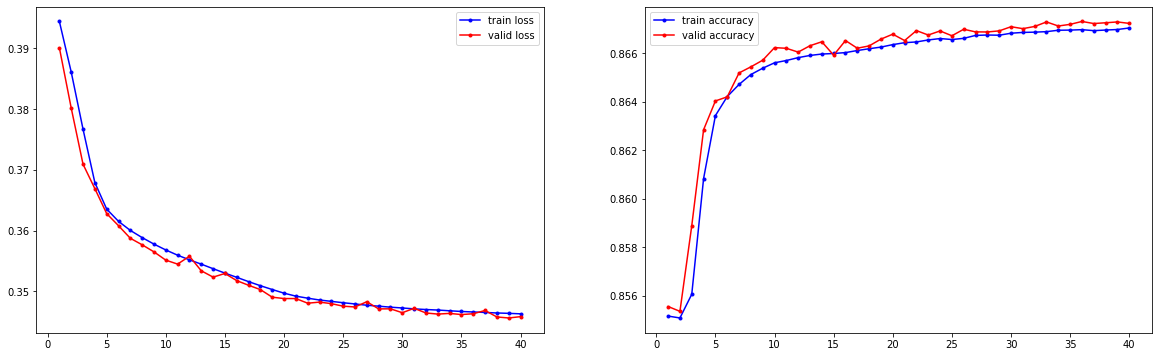

In [41]:
plot_training_classification(run_hist)

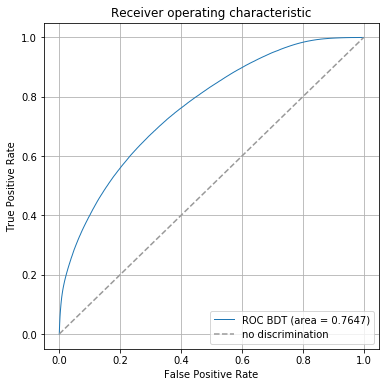

In [42]:
print_roc(model,X_valid, Y_valid )

In [43]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN_2.pt")


In [46]:
learning_rate = 5e-5
optimizer_2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer_2, run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.3454, train acc: 0.8672, elapsed:164.9140


valid loss: 0.3449, valid acc: 0.8675, elapsed:18.5357

Epoch 2/10
----------


train loss: 0.3454, train acc: 0.8672, elapsed:167.9571


valid loss: 0.3453, valid acc: 0.8674, elapsed:20.6009

Epoch 3/10
----------


train loss: 0.3454, train acc: 0.8673, elapsed:170.0375


valid loss: 0.3449, valid acc: 0.8675, elapsed:18.8440

Epoch 4/10
----------


train loss: 0.3454, train acc: 0.8673, elapsed:162.3280


valid loss: 0.3449, valid acc: 0.8675, elapsed:18.9834

Epoch 5/10
----------


train loss: 0.3453, train acc: 0.8673, elapsed:164.4092


valid loss: 0.3449, valid acc: 0.8676, elapsed:18.7090

Epoch 6/10
----------


train loss: 0.3453, train acc: 0.8673, elapsed:163.1146


valid loss: 0.3448, valid acc: 0.8675, elapsed:18.8034

Epoch 7/10
----------


train loss: 0.3452, train acc: 0.8673, elapsed:160.9497


valid loss: 0.3451, valid acc: 0.8676, elapsed:18.8336

Epoch 8/10
----------


train loss: 0.3452, train acc: 0.8673, elapsed:161.2013


valid loss: 0.3447, valid acc: 0.8675, elapsed:18.9533

Epoch 9/10
----------


train loss: 0.3452, train acc: 0.8673, elapsed:164.4706


valid loss: 0.3449, valid acc: 0.8675, elapsed:21.4646

Epoch 10/10
----------


train loss: 0.3451, train acc: 0.8673, elapsed:160.6112


valid loss: 0.3448, valid acc: 0.8676, elapsed:18.8461
training took:  1832.5726585730445


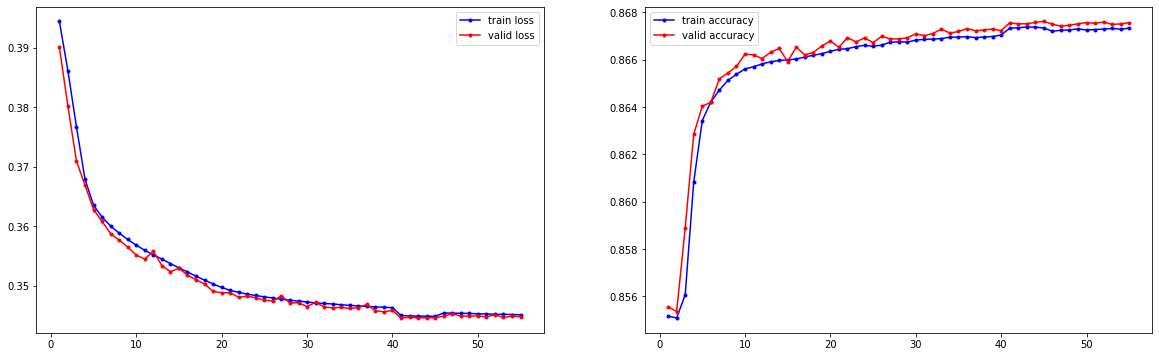

In [48]:
plot_training_classification(run_hist)

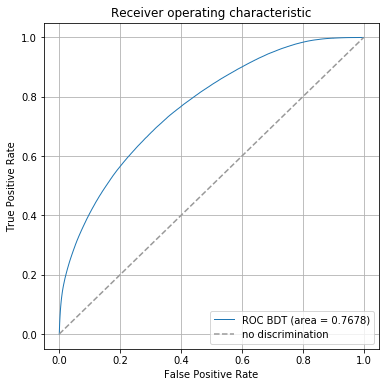

In [49]:
print_roc(model,X_valid, Y_valid )

In [51]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_2.state_dict(),
            'run_history':run_hist,
            }, ".4NN_3.pt")

In [141]:
weights = [0.1, 0.9]
class_weights = torch.FloatTensor(weights).to(device)
criterion_3 = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 1e-4
optimizer_3 = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [165]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [144]:
model, run_hist = train_and_valid_classification(model, criterion_3, optimizer_3, run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.5645, train acc: 0.5384, elapsed:158.9666


valid loss: 0.5556, valid acc: 0.5779, elapsed:17.9320

Epoch 2/10
----------


train loss: 0.5530, train acc: 0.5428, elapsed:158.0815


valid loss: 0.5524, valid acc: 0.5570, elapsed:19.3472

Epoch 3/10
----------


train loss: 0.5516, train acc: 0.5455, elapsed:162.1999


valid loss: 0.5510, valid acc: 0.5668, elapsed:18.1548

Epoch 4/10
----------


train loss: 0.5509, train acc: 0.5471, elapsed:161.4234


valid loss: 0.5522, valid acc: 0.5468, elapsed:17.7234

Epoch 5/10
----------


train loss: 0.5502, train acc: 0.5482, elapsed:157.7338


valid loss: 0.5511, valid acc: 0.5326, elapsed:17.9182

Epoch 6/10
----------


train loss: 0.5497, train acc: 0.5496, elapsed:154.1905


valid loss: 0.5494, valid acc: 0.5410, elapsed:17.9281

Epoch 7/10
----------


train loss: 0.5492, train acc: 0.5505, elapsed:158.1119


valid loss: 0.5494, valid acc: 0.5580, elapsed:17.9632

Epoch 8/10
----------


train loss: 0.5489, train acc: 0.5516, elapsed:158.3913


valid loss: 0.5481, valid acc: 0.5544, elapsed:18.2131

Epoch 9/10
----------


train loss: 0.5486, train acc: 0.5523, elapsed:161.0721


valid loss: 0.5485, valid acc: 0.5383, elapsed:19.7551

Epoch 10/10
----------


train loss: 0.5483, train acc: 0.5526, elapsed:156.9583


valid loss: 0.5494, valid acc: 0.5250, elapsed:18.2584
training took:  1770.327840322163


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


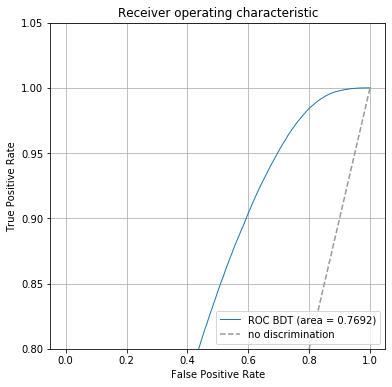

In [145]:
print_roc(model,X_valid, Y_valid )

In [149]:
model, run_hist = train_and_valid_classification(model, criterion_3, optimizer_3, run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.5480, train acc: 0.5531, elapsed:156.5470


valid loss: 0.5494, valid acc: 0.5104, elapsed:18.1243

Epoch 2/10
----------


train loss: 0.5478, train acc: 0.5532, elapsed:155.9909


valid loss: 0.5483, valid acc: 0.5518, elapsed:20.0363

Epoch 3/10
----------


train loss: 0.5476, train acc: 0.5536, elapsed:158.8983


valid loss: 0.5481, valid acc: 0.5815, elapsed:19.3740

Epoch 4/10
----------


train loss: 0.5474, train acc: 0.5538, elapsed:160.2956


valid loss: 0.5485, valid acc: 0.5240, elapsed:18.1201

Epoch 5/10
----------


train loss: 0.5473, train acc: 0.5542, elapsed:159.8172


valid loss: 0.5479, valid acc: 0.5251, elapsed:17.9560

Epoch 6/10
----------


train loss: 0.5472, train acc: 0.5548, elapsed:160.1252


valid loss: 0.5474, valid acc: 0.5369, elapsed:18.0939

Epoch 7/10
----------


train loss: 0.5470, train acc: 0.5545, elapsed:159.2406


valid loss: 0.5476, valid acc: 0.5672, elapsed:18.4404

Epoch 8/10
----------


train loss: 0.5469, train acc: 0.5549, elapsed:164.9834


valid loss: 0.5474, valid acc: 0.5384, elapsed:20.7339

Epoch 9/10
----------


train loss: 0.5468, train acc: 0.5552, elapsed:159.3115


valid loss: 0.5470, valid acc: 0.5515, elapsed:18.0269

Epoch 10/10
----------


train loss: 0.5467, train acc: 0.5556, elapsed:157.3932


valid loss: 0.5468, valid acc: 0.5779, elapsed:18.2151
training took:  1779.730148483999


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


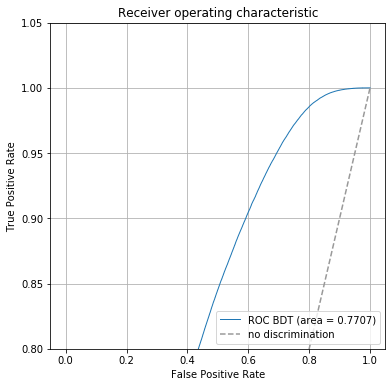

In [150]:
print_roc(model,X_valid, Y_valid )

In [163]:
def print_classification_report(model, X, Y):
    def predict_vs_threshold(probas,threshold):
        predicted = np.where(probas>threshold,1,0)
        return predicted

    
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)
    probas = F.softmax(output)
    print(classification_report(Y, predict_vs_threshold(probas[:,1], 0.3), target_names=["ghost","true"]))



In [164]:
print_classification_report(model,X_valid, Y_valid)

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

       ghost       0.98      0.24      0.38   1100498
        true       0.18      0.97      0.30    185790

   micro avg       0.35      0.35      0.35   1286288
   macro avg       0.58      0.61      0.34   1286288
weighted avg       0.87      0.35      0.37   1286288



In [169]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_3.state_dict(),
            'run_history':run_hist,
            }, ".4NN_weighted_loss_1.pt")

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


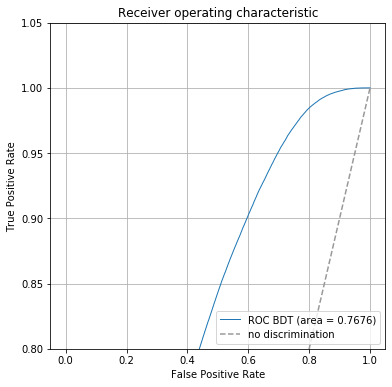

In [174]:
print_roc(model,X_valid, Y_valid )